In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import InputLayer, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
# !unzip /content/drive/MyDrive/archive.zip

In [8]:
df = pd.read_csv('Training_set.csv')
df.shape

(6499, 2)

In [9]:
df.head()

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


In [10]:
df.isna().sum()

,0
filename,0
label,0


In [11]:
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])
df.head()

,filename,label,label_encoded
0,Image_1.jpg,SOUTHERN DOGFACE,66
1,Image_2.jpg,ADONIS,0
2,Image_3.jpg,BROWN SIPROETA,12
3,Image_4.jpg,MONARCH,44
4,Image_5.jpg,GREEN CELLED CATTLEHEART,33


In [12]:
df.label.value_counts()

,count
label,
MOURNING CLOAK,131
SLEEPY ORANGE,107
ATALA,100
BROWN SIPROETA,99
SCARCE SWALLOW,97
...,...
AMERICAN SNOOT,74
GOLD BANDED,73
MALACHITE,73


In [13]:
df.label_encoded.value_counts()

,count
label_encoded,
45,131
64,107
5,100
12,99
62,97
...,...
2,74
30,73
39,73


In [14]:
X = []
for img in df.filename.values:
  temp = plt.imread('train/'+img)
  X.append(temp)

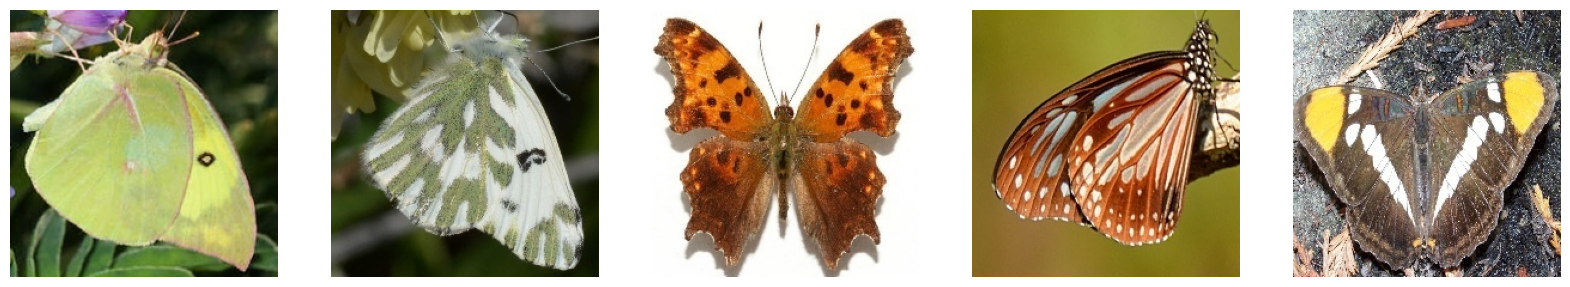

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))
for i in range(5):
  ax[i].imshow(X[i*100])
  ax[i].axis('Off')

In [16]:
X = np.array(X)

In [17]:
X.shape

(6499, 224, 224, 3)

In [18]:
X.max(), X.min()

(np.uint8(255), np.uint8(0))

In [19]:
X = X.astype('float32')
X /= X.max()
X.max(), X.min()

(np.float32(1.0), np.float32(0.0))

In [20]:
X = X.reshape(X.shape[0], 224*224*3)

In [21]:
X.shape

(6499, 150528)

In [22]:
y = df['label_encoded']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [24]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5199, 150528), (5199,), (1300, 150528), (1300,))

# **OR**

In [25]:
data = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [26]:
train_data = data.flow_from_dataframe(
    dataframe=df,
    directory='/content/train',
    x_col='filename',
    y_col='label',
    target_size=(48, 48),
    class_mode='categorical',
    subset='training',
    batch_size=32
)

Found 5200 validated image filenames belonging to 75 classes.


In [27]:
val_data = data.flow_from_dataframe(
    dataframe=df,
    directory='/content/train',
    x_col='filename',
    y_col='label',
    target_size=(48, 48),
    class_mode='categorical',
    subset='validation',
    batch_size=32
)

Found 1299 validated image filenames belonging to 75 classes.


In [50]:
model = Sequential([
    InputLayer(input_shape=(48, 48, 3)),
    Flatten(),
    Dense(units=1000, activation='relu'),
    Dense(units=1000, activation='relu'),
    Dense(units=1000, activation='relu'),
    Dense(units=75, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [51]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 6912)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1000)           │     6,913,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 75)             │        75,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,990,075 (34.29 MB)

 Trainable params: 8,990,075 (34.29 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [53]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, restore_best_weights=True, patience=3, mode='min')

In [54]:
model_history = model.fit(train_data, validation_data=val_data, epochs=50, callbacks=[early_stopping])

Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 30s 171ms/step - accuracy: 0.0302 - loss: 4.5504 - val_accuracy: 0.0570 - val_loss: 3.7847
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 156ms/step - accuracy: 0.0950 - loss: 3.5457 - val_accuracy: 0.1263 - val_loss: 3.3121
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 156ms/step - accuracy: 0.1618 - loss: 3.2084 - val_accuracy: 0.1978 - val_loss: 3.0788
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 155ms/step - accuracy: 0.2205 - loss: 2.8757 - val_accuracy: 0.1832 - val_loss: 3.1483
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 43s 168ms/step - accuracy: 0.2664 - loss: 2.6624 - val_accuracy: 0.2256 - val_loss: 3.0018
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 152ms/step - accuracy: 0.3047 - loss: 2.4951 - val_accuracy: 0.2564 - val_loss: 2.7828
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 162ms/step - accuracy: 0.3490 - loss: 2.2971 - val_accuracy: 0.2787 - val_loss: 2.8082
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 162ms/step - accuracy: 0.3786 - loss: 2

In [55]:
# Predict probabilities for validation data
y_pred_probs = model.predict(val_data)

# Convert probabilities → predicted class indices
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = val_data.classes
accuracy_score(y_true, y_pred_classes)

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step


0.014626635873749037

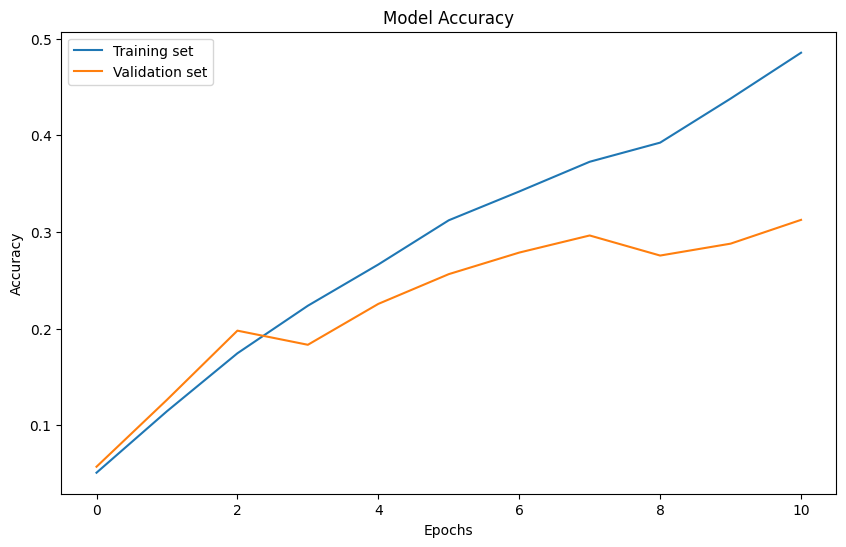

In [56]:
plt.figure(figsize=(10, 6))
plt.plot(model_history.history['accuracy'], label='Training set')
plt.plot(model_history.history['val_accuracy'], label='Validation set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

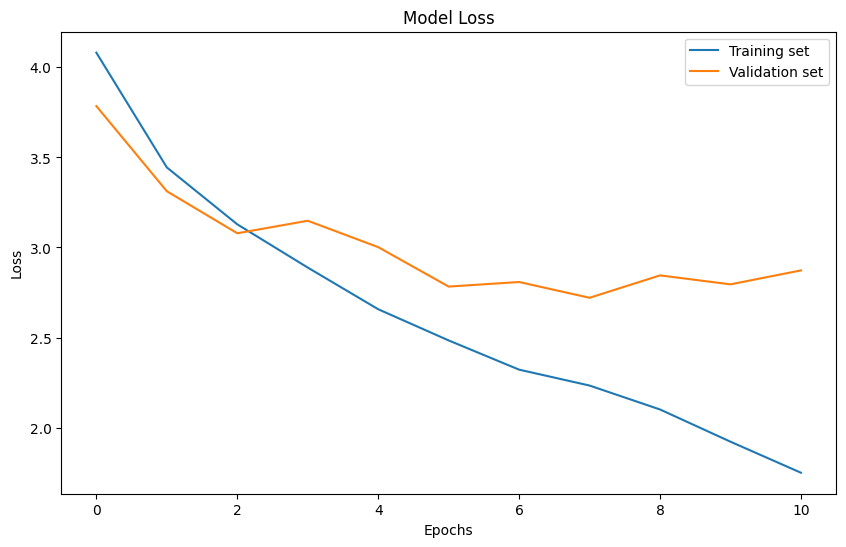

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(model_history.history['loss'], label='Training set')
plt.plot(model_history.history['val_loss'], label='Validation set')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

In [66]:
model = Sequential([
    InputLayer(input_shape=(48, 48, 3)),
    Flatten(),
    Dense(units=1000, activation='relu'),
    Dropout(rate=0.3),
    Dense(units=1000, activation='relu'),
    Dropout(rate=0.3),
    Dense(units=1000, activation='relu'),
    Dropout(rate=0.2),
    Dense(units=75, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [67]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_6 (Flatten)             │ (None, 6912)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1000)           │     6,913,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 75)             │        75,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,990,075 (34.29 MB)

 Trainable params: 8,990,075 (34.29 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_history = model.fit(train_data, validation_data=val_data, epochs=50)

Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 29s 170ms/step - accuracy: 0.0212 - loss: 4.7445 - val_accuracy: 0.0554 - val_loss: 4.0271
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 28s 169ms/step - accuracy: 0.0528 - loss: 4.0235 - val_accuracy: 0.0816 - val_loss: 3.6621
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 30s 181ms/step - accuracy: 0.0516 - loss: 3.7916 - val_accuracy: 0.0824 - val_loss: 3.6139
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 29s 181ms/step - accuracy: 0.0761 - loss: 3.6781 - val_accuracy: 0.0654 - val_loss: 3.6065
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 164ms/step - accuracy: 0.0796 - loss: 3.5999 - val_accuracy: 0.1016 - val_loss: 3.4358
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 168ms/step - accuracy: 0.0865 - loss: 3.5566 - val_accuracy: 0.1132 - val_loss: 3.4227
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 28s 172ms/step - accuracy: 0.0954 - loss: 3.5116 - val_accuracy: 0.1093 - val_loss: 3.4363
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 28s 171ms/step - accuracy: 0.0977 - loss: 3

In [69]:
# Predict probabilities for validation data
y_pred_probs = model.predict(val_data)

# Convert probabilities → predicted class indices
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = val_data.classes
accuracy_score(y_true, y_pred_classes)

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step


0.016166281755196306

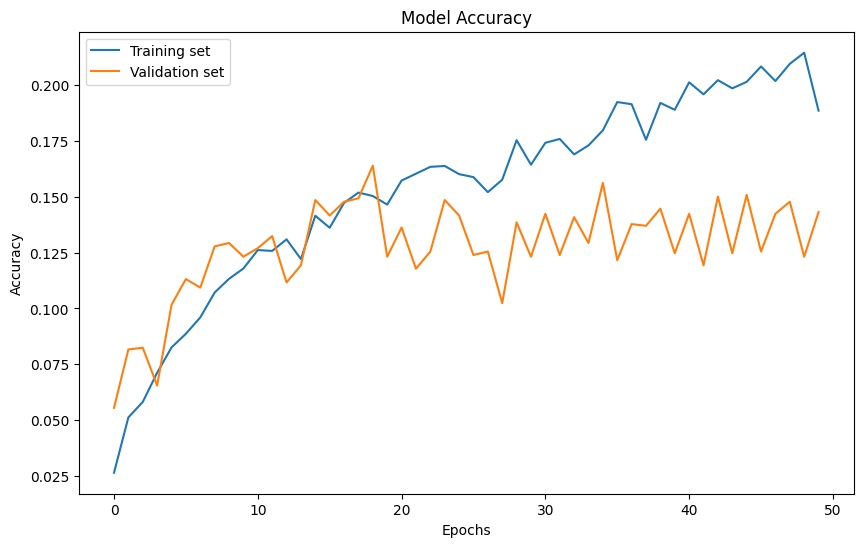

In [70]:
plt.figure(figsize=(10, 6))
plt.plot(model_history.history['accuracy'], label='Training set')
plt.plot(model_history.history['val_accuracy'], label='Validation set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

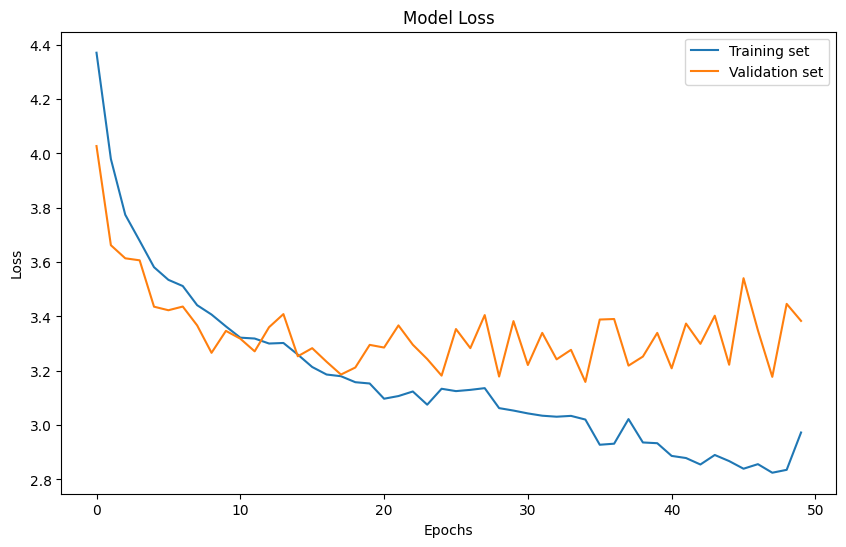

In [71]:
plt.figure(figsize=(10, 6))
plt.plot(model_history.history['loss'], label='Training set')
plt.plot(model_history.history['val_loss'], label='Validation set')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()